## Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import logging
import joblib
import torch

import os 
os.chdir('/home/itingzon.unicef/giga')
from utils import calib_utils
from utils import post_utils
from utils import config_utils
from utils import eval_utils
from utils import model_utils

%load_ext autoreload
%autoreload 2

## Load Config Files

In [33]:
iso_code = "ZWE"
data_config_file = os.path.join(os.getcwd(), "configs/data_configs/data_config_ISO_AF.yaml")
config_file = os.path.join(os.getcwd(), "configs/best_models.yaml")
data_config = config_utils.load_config(data_config_file)
config = config_utils.create_config(config_file)

## Load Validation Results

In [34]:
val_output = model_utils.ensemble_models(iso_code, config, phase="val")
test_output = model_utils.ensemble_models(iso_code, config, phase="test")
test_output.head(3)

,UID,source,iso,country,region,subregion,name,giga_id_school,clean,validated,class,ghsl_smod,rurban,dataset,geometry,y_true,y_preds,y_probs
0,OSM-ZWE-SCHOOL-00000004,OSM,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,NaN,0,0.0,school,12,rural,test,POINT (2704069.5261203847 -2219565.275443977),1,1,0.943400
1,OSM-ZWE-SCHOOL-00000011,OSM,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,NaN,0,0.0,school,12,rural,test,POINT (2715275.2840541867 -2249114.3491961244),1,1,0.949903
2,OSM-ZWE-SCHOOL-00000015,OSM,ZWE,Zimbabwe,Africa,Sub-Saharan Africa,NaN,NaN,0,0.0,school,12,rural,test,POINT (2689064.291227972 -2273314.611955284),1,1,0.946239


## Load Evaluation

In [35]:
val_results = eval_utils.evaluate(
    y_true=val_output["y_true"], 
    y_pred=val_output["y_preds"], 
    y_prob=val_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2
)
test_results = eval_utils.evaluate(
    y_true=test_output["y_true"], 
    y_pred=test_output["y_preds"], 
    y_prob=test_output["y_probs"], 
    pos_label=1, 
    neg_label=0,
    beta=2,
    optim_threshold=val_results["optim_threshold"]
)
test_results

{'auprc': 0.9957214092495752,
 'ap': 0.9957214092495752,
 'roc_auc': 0.9976318346197443,
 'brier_score': 0.026836262613505472,
 'precision_scores_': array([0.33680556, 0.33709818, 0.3373913 , ..., 1.        , 1.        ,
        1.        ]),
 'recall_scores_': array([1.        , 1.        , 1.        , ..., 0.00515464, 0.00257732,
        0.        ]),
 'thresholds_': array([0.044674  , 0.04503037, 0.04561864, ..., 0.95999597, 0.96014363,
        0.96213575]),
 'optim_threshold': 0.32652765884995455,
 'fbeta_score': 97.66615930999492,
 'precision_score': 91.8854415274463,
 'recall_score': 99.22680412371135,
 'overall_accuracy': 96.78819444444444,
 'balanced_accuracy': 97.38827117180331}

## Plot Results

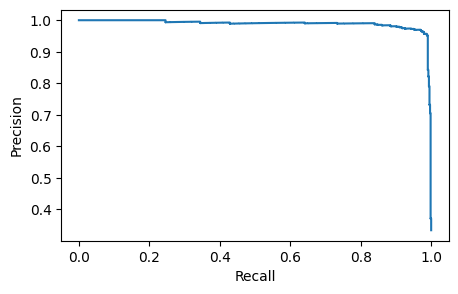

In [149]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
disp = PrecisionRecallDisplay(
    precision=test_results['precision_scores_'], 
    recall=test_results['recall_scores_']
)
disp.plot(ax=ax);

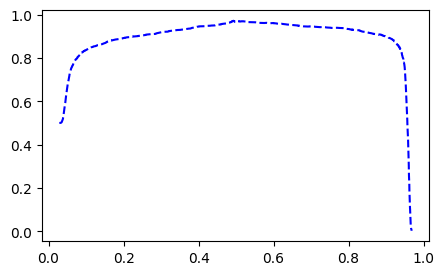

In [152]:
_, test_fscores = eval_utils.get_optimal_threshold(
    test_results['precision_scores_'], 
    test_results['recall_scores_'], 
    test_results['thresholds_'], 
    beta=1
)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['thresholds_'], test_fscores[:-1], "b--");

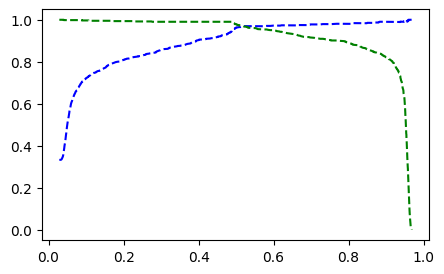

In [153]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(test_results['thresholds_'], test_results['precision_scores_'][:-1], "b--")
ax.plot(test_results['thresholds_'], test_results['recall_scores_'][:-1], "g--");